<a href="https://colab.research.google.com/github/vu-topics-in-big-data-2021/project-crypto-group16/blob/main/Query1_Query2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Queries 1 and 2

## Setup 

In [1]:
#install the required packages
!pip3 install influxdb plotly pandas numpy matplotlib

     |████████████████████████████████| 81kB 4.1MB/s 


In [2]:
from influxdb import InfluxDBClient
import json
import os
import datetime
from getpass import getpass
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
usrnme=getpass('Enter Username Here:')
passwd=getpass('Enter Password Here:')
client = InfluxDBClient(host='100.25.103.36', username=usrnme, password=passwd, port=8086, database="crypto_forex")

Enter Username Here:··········
Enter Password Here:··········


In [4]:
try:
    d = client.get_list_database()
    assert str(d) == "[{'name': '_internal'}, {'name': 'crypto_forex'}]"
    print("Successfully connected to DB")
except AssertionError:
    print("InfluxDB not configured correctly. Databases listed below")
    print(client.get_list_database())
    quit()

Successfully connected to DB


Q1. Plot cryptocurrency, currency price change
- Rolling average (by month)
- Foreign Exchange Market currencies: group currencies by continent, but have USD, EUR, GBP, JPY, CNY as their own category. 
- Normalize the changes



In [5]:
crypto_list = [
            "X:BTCUSD",
            "X:ETHUSD",
            "X:USDTUSD",
            "X:BNBUSD",
            "X:ADAUSD",
            "X:XRPUSD",
            "X:LTCUSD",
            "X:LINKUSD",
            "X:USDCUSD",
            "X:BCHUSD",
            "X:XLMUSD",
            "X:DOGEUSD"]

na_fx = ['C:CADUSD',
 'C:MXNUSD']

sa_fx = ['C:BRLUSD',
 'C:ARSUSD',
 'C:BOBUSD',
 'C:CLPUSD',
 'C:COPUSD']

ww_fx = [ 'C:EURUSD',
 'C:AUDUSD',
 'C:NZDUSD']

eu_fx = ['C:GBPUSD',
 'C:SEKUSD',
 'C:CHFUSD',
 'C:HUFUSD',
 'C:RUBUSD']

as_fx = ['C:JPYUSD',
 'C:CNYUSD',
 'C:HKDUSD',
 'C:KRWUSD',
 'C:INRUSD']

af_fx = ['C:ZARUSD',
 'C:LYDUSD',
 'C:TNDUSD',
 'C:MADUSD',
 'C:GHSUSD']

all_fx = na_fx + sa_fx + ww_fx + eu_fx + as_fx + af_fx

## Defined Functions

In [6]:
# Just a basic data pull where we are getting the mean closing price of a pair
def tema_close(pair):
    """
    :return: DataFrame
    """
    query_str= f"""
    SELECT TRIPLE_EXPONENTIAL_MOVING_AVERAGE(mean("c"),14) AS TEMA_{pair[2:]}
    FROM crypto_forex
    WHERE time >= '2014-12-31T00:00:00Z'
    AND time < '2021-04-01T00:00:00Z'
    AND pair = '{pair}' 
    GROUP BY time(12h)
    FILL(null)
    """
    
    # return pd.DataFrame(client.query(query_str).get_points('crypto_forex'))
    df = pd.DataFrame(client.query(query_str).get_points('crypto_forex'))
    df["time"] = df["time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
    df = df.set_index("time")
    return df

In [7]:
df = tema_close("X:BTCUSD")

In [8]:
df.first_valid_index()

Timestamp('2017-01-07 12:00:00')

Before 

In [9]:
def q_join(pairList):
    df = pd.DataFrame()
    for i in pairList:
        tmp_df = tema_close(i)
        if df.empty:
           df = tmp_df
        else:
            new_df = pd.merge(left=df,
                              right=tmp_df,
                              how="left",
                              on = "time",
                              left_index=True)
            df = new_df
    return df

In [10]:
def save_plot(plot, name, directory=""):
    if directory is None:
        path = "figures/q1"
    else:
        path = f"figures/q1/{directory}"

    if not os.path.exists(path):
        os.makedirs(path)
    plot.figure.savefig(f"{path}/{name}.png")

In [11]:
def normalize(df, how="minmax"):
    assert how == "minmax" or how == "zscore"
    ndf = pd.DataFrame()
    if how == "minmax":
        for i in df.columns:
        # all values betwen 0 and 1
            ndf[i] = (df[i] - df[i].min()) / df[i].max()
    else:
        for i in df.columns:
            # z score normalized
            ndf[i] = (df[i] - df[i].mean()) / df[i].std()
    return ndf

In [12]:
def mRolling(name, lst):
    df = q_join(lst)
    first_date = df.iloc[:,0].first_valid_index()
    # plot = df.loc[first_date:].plot(kind="line",
    #                 figsize=(20,10*len(df.columns)),
    #                 subplots=True,
    #                 title=f"{name} 7 Day Rolling Mean Price",
    #                 xlabel="time (7 day)",
    #                 ylabel="USD($)")
    plot = df.plot(kind="line",
                figsize=(20,10*len(df.columns)),
                subplots=True,
                title=f"{name} 7 Day Rolling Mean Price",
                xlabel="time (7 day)",
                ylabel="USD($)")
    for i in plot:
        save_plot(i, name=f"{name}_subplot", directory="all-rolling-subplots")

    ndf = normalize(df)
    nplot = ndf.loc[first_date:].plot(kind="line",
                                    figsize=(20,20),
                                    title=f"{name} Normalized 7 Day TEMA Closing Price grouped by 12 hours",
                                    xlabel="time (7 day)",
                                    ylabel="USD($)")
    save_plot(nplot, name=f"all_{name}_normalized", directory="normalized")
    return

## Query 1
Plot cryptocurrency, currency price change
- Rolling average (by month)
- Foreign Exchange Market currencies: group currencies by continent, but have USD, EUR, GBP, JPY, CNY as their own category. 
- Normalize the changes

### Cryptocurrencies

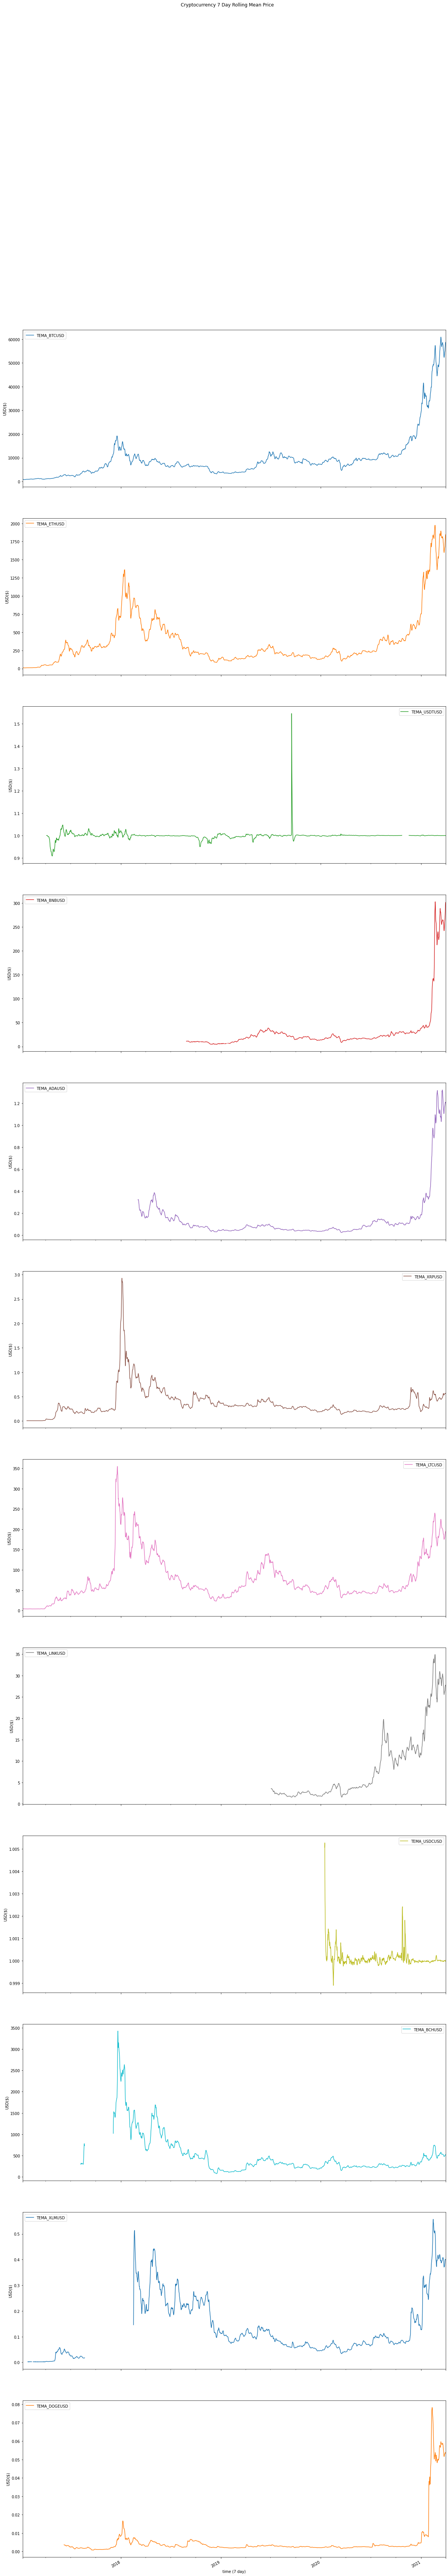

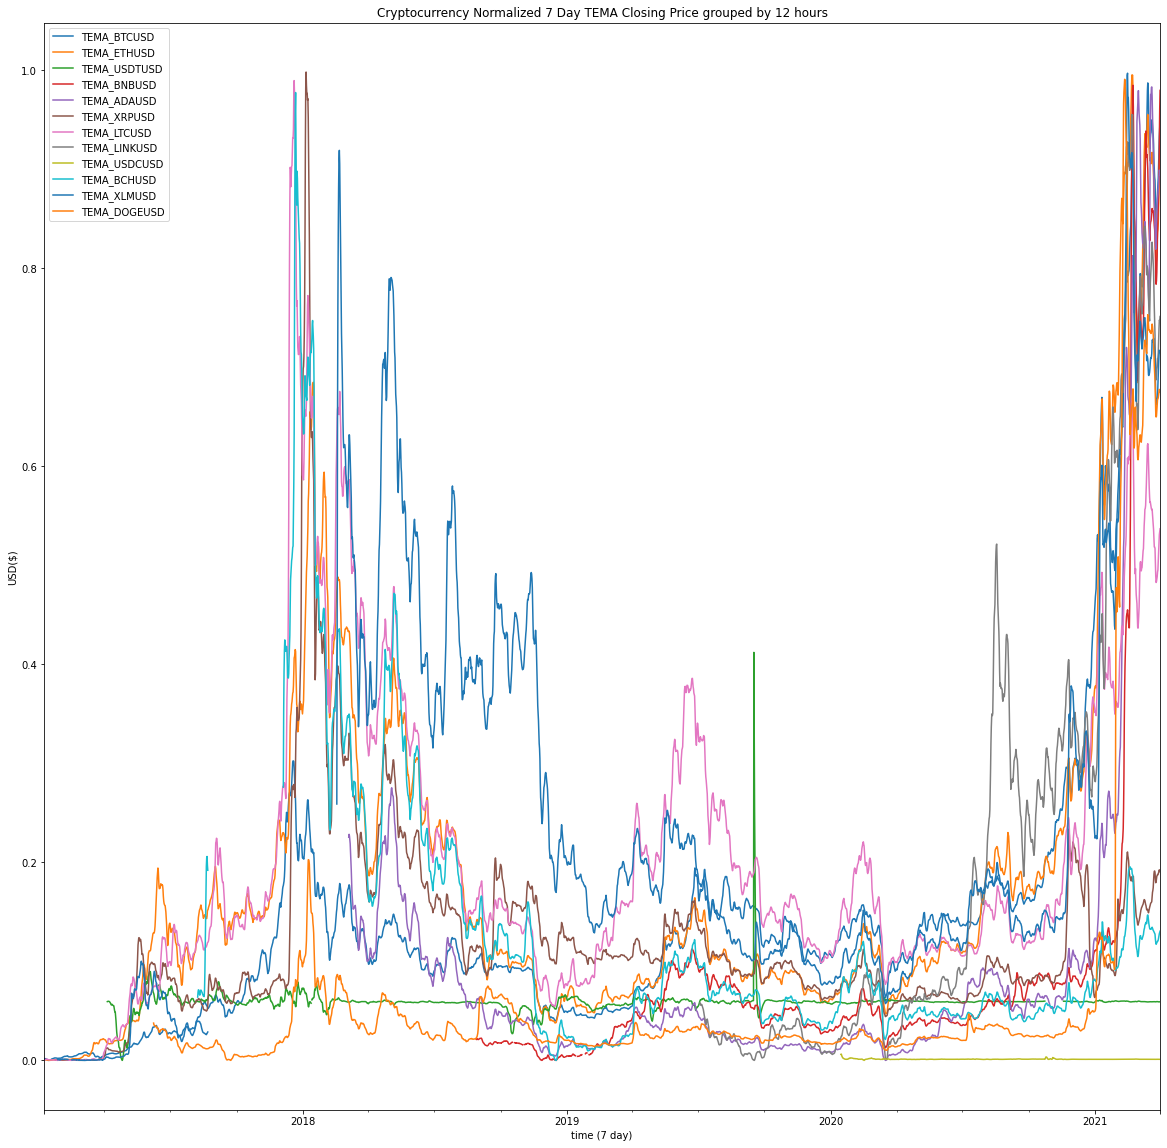

In [13]:
mRolling(name="Cryptocurrency", lst=crypto_list)

### By continent

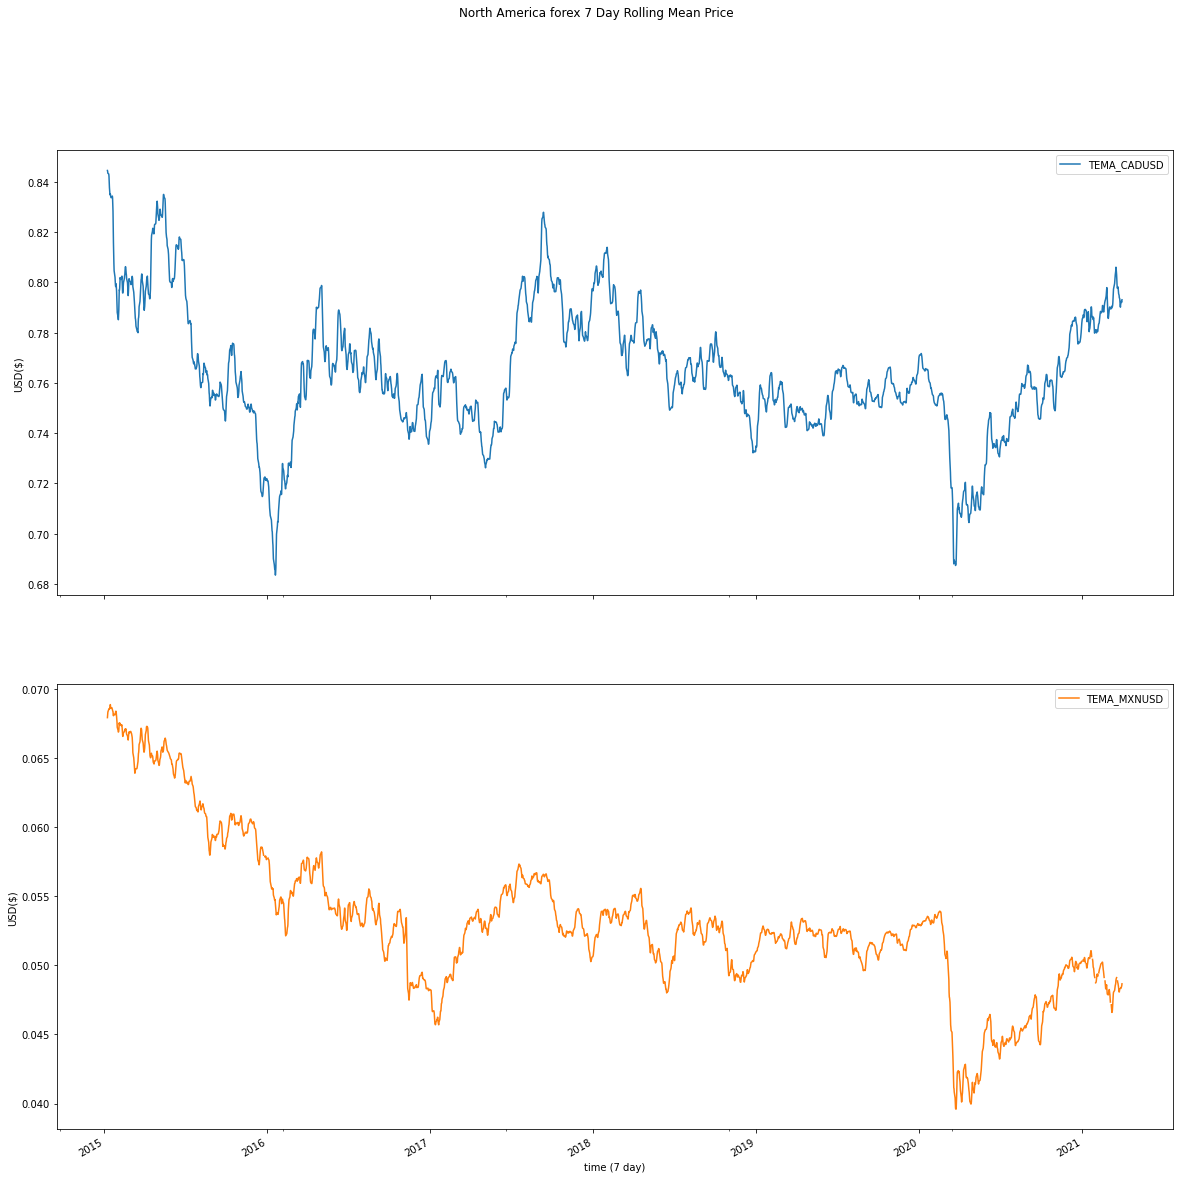

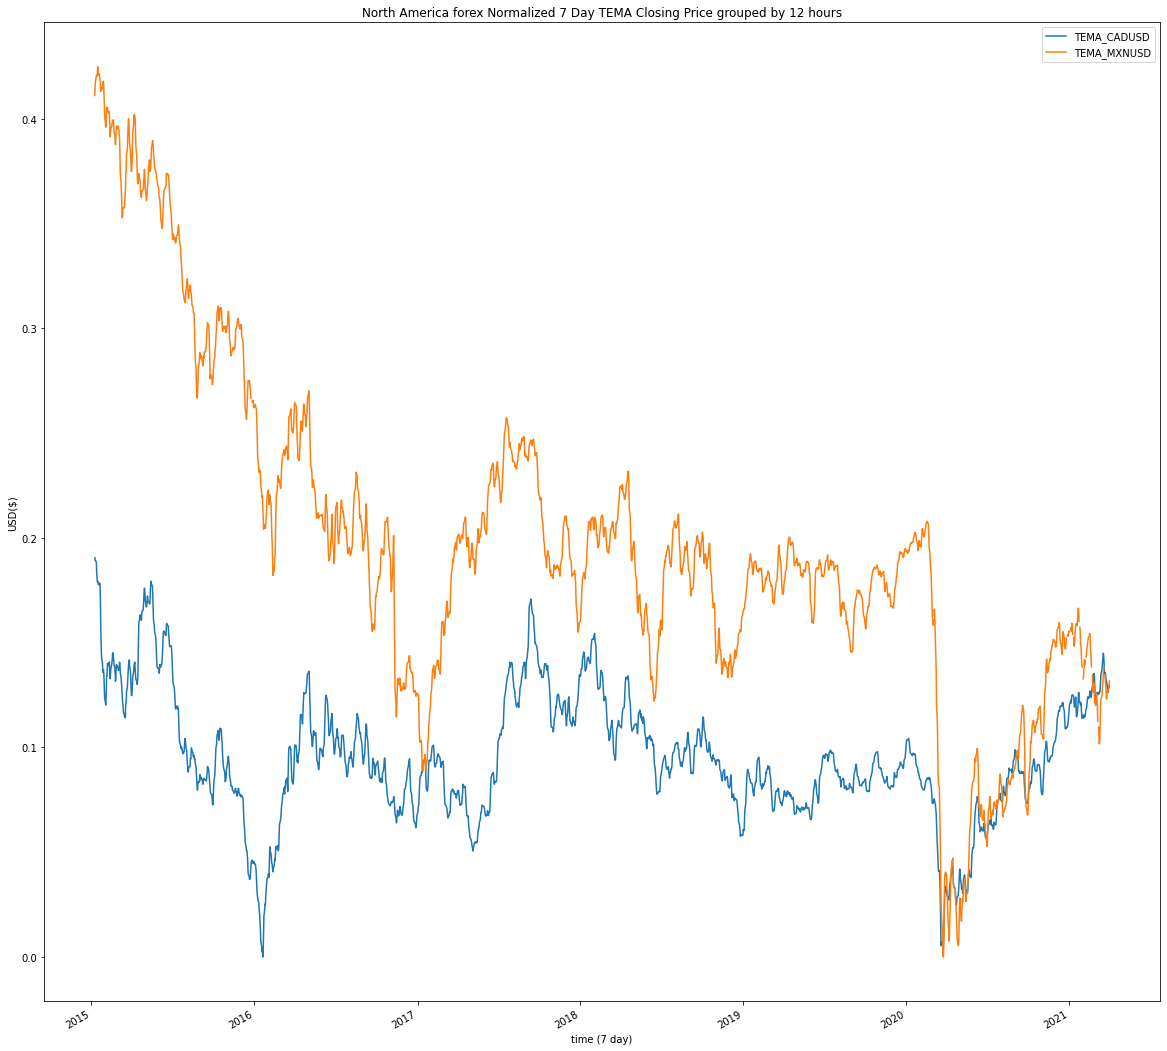

In [14]:
mRolling(name="North America forex", lst=na_fx)

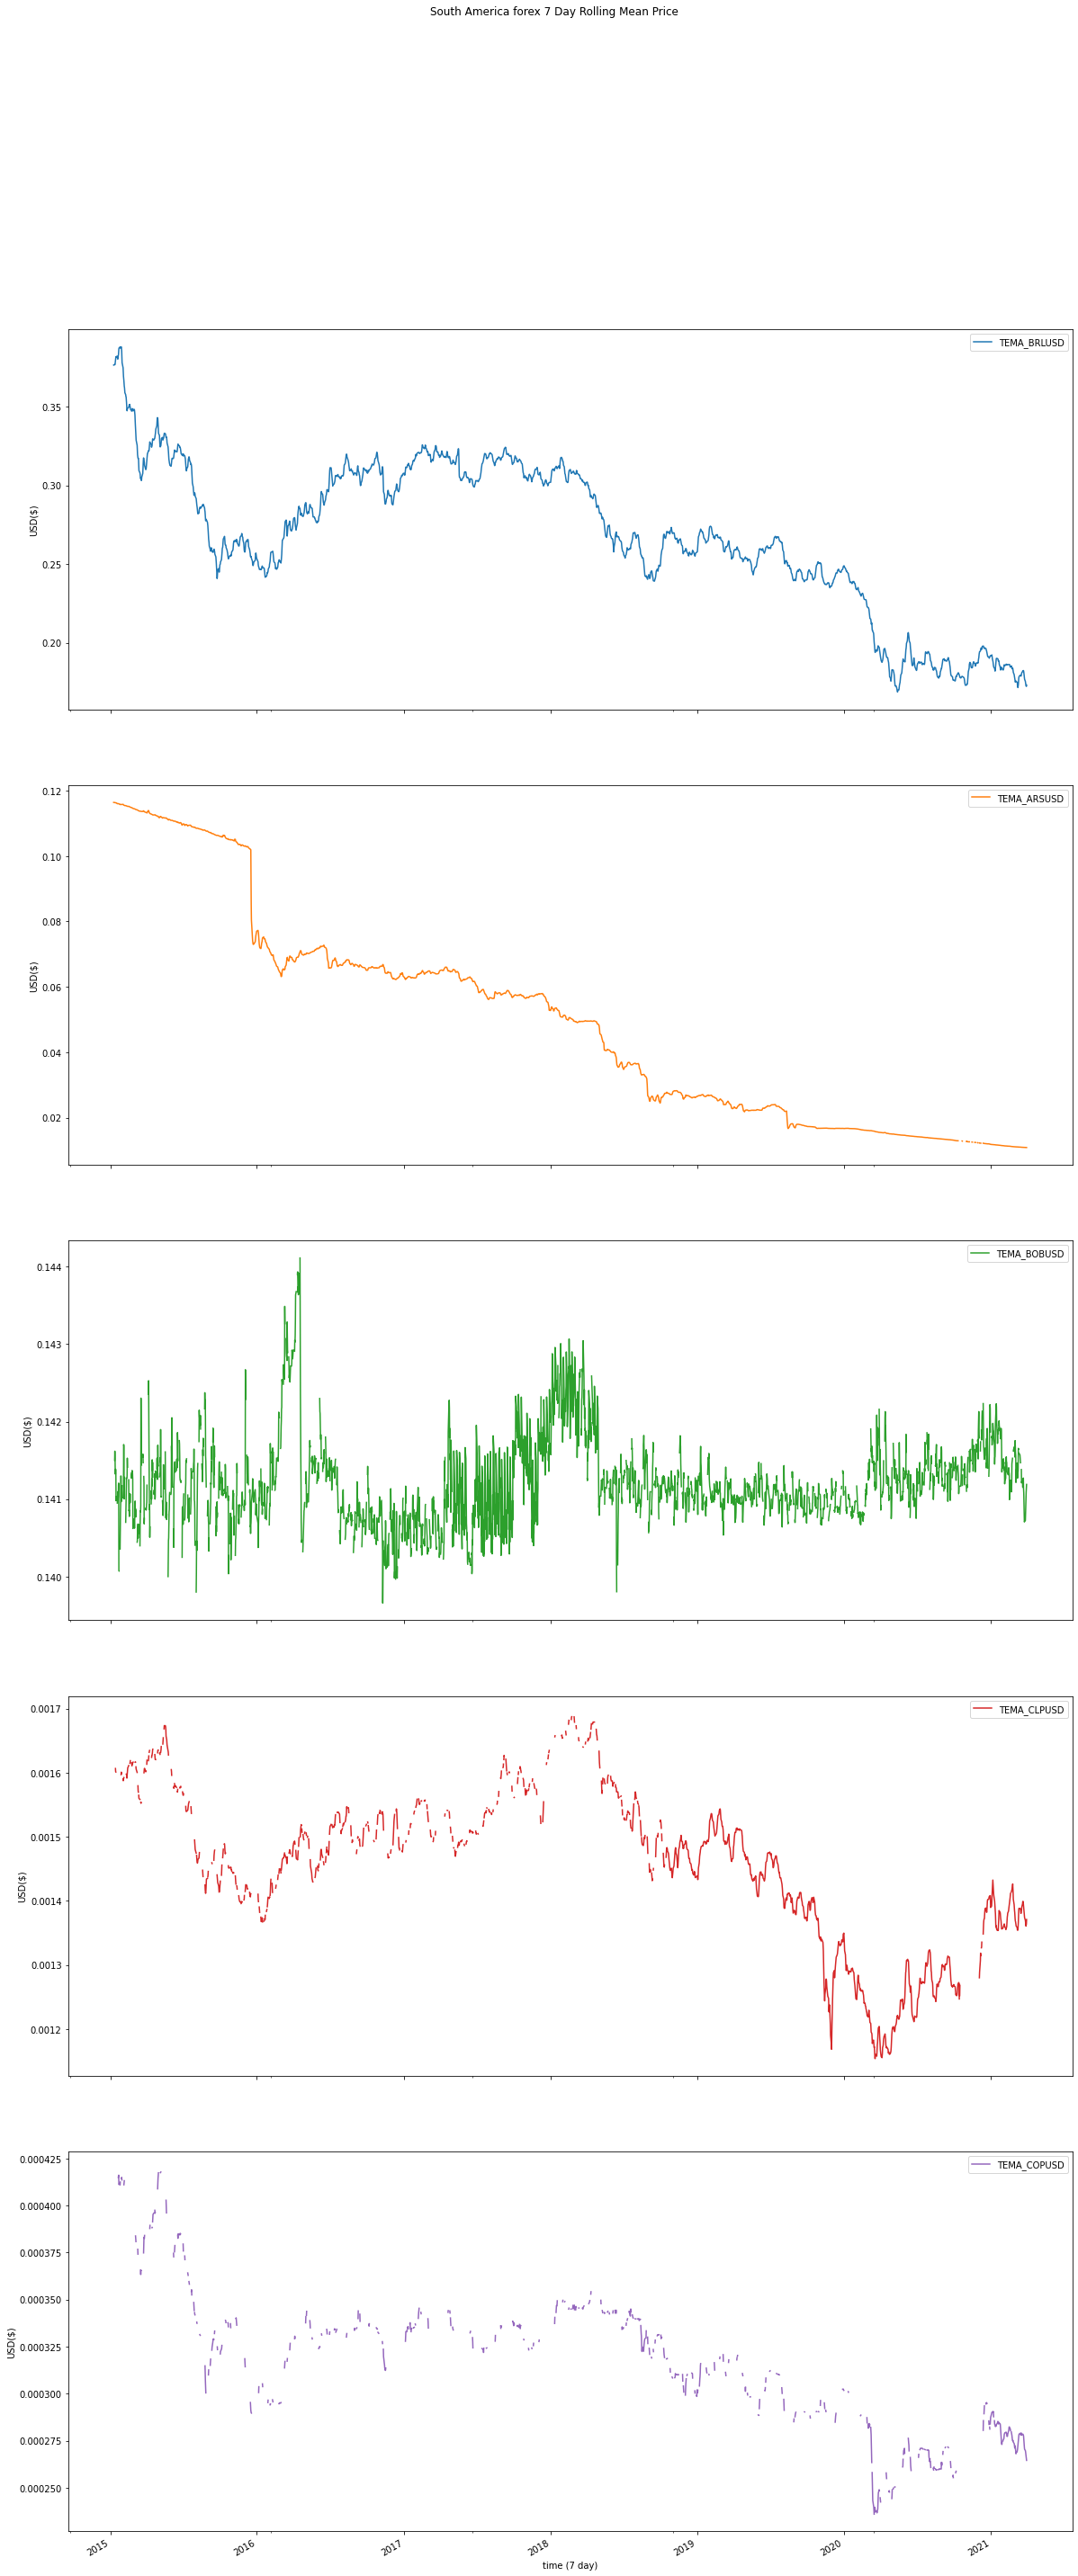

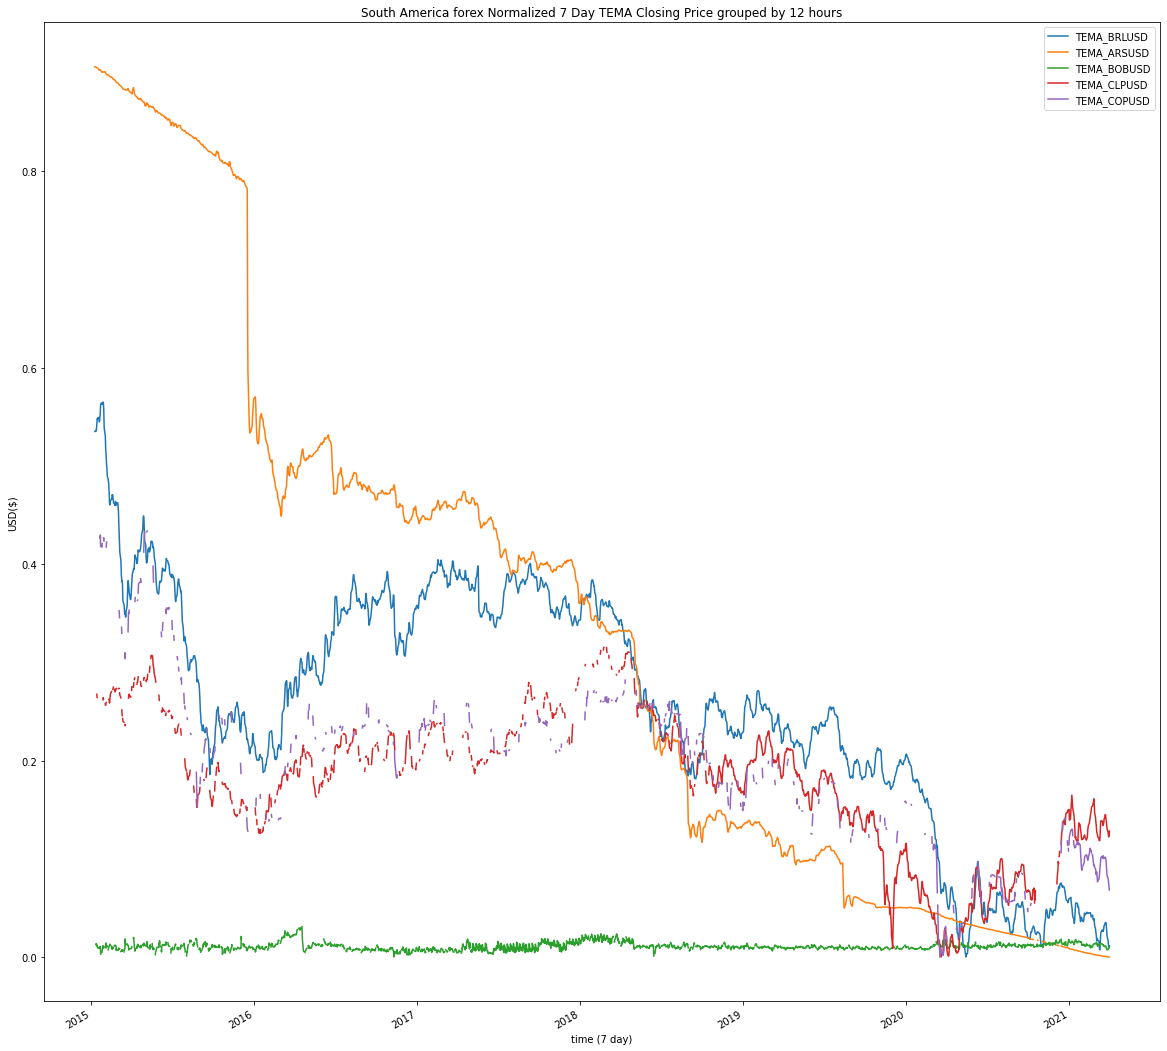

In [15]:
mRolling(name="South America forex", lst=sa_fx)

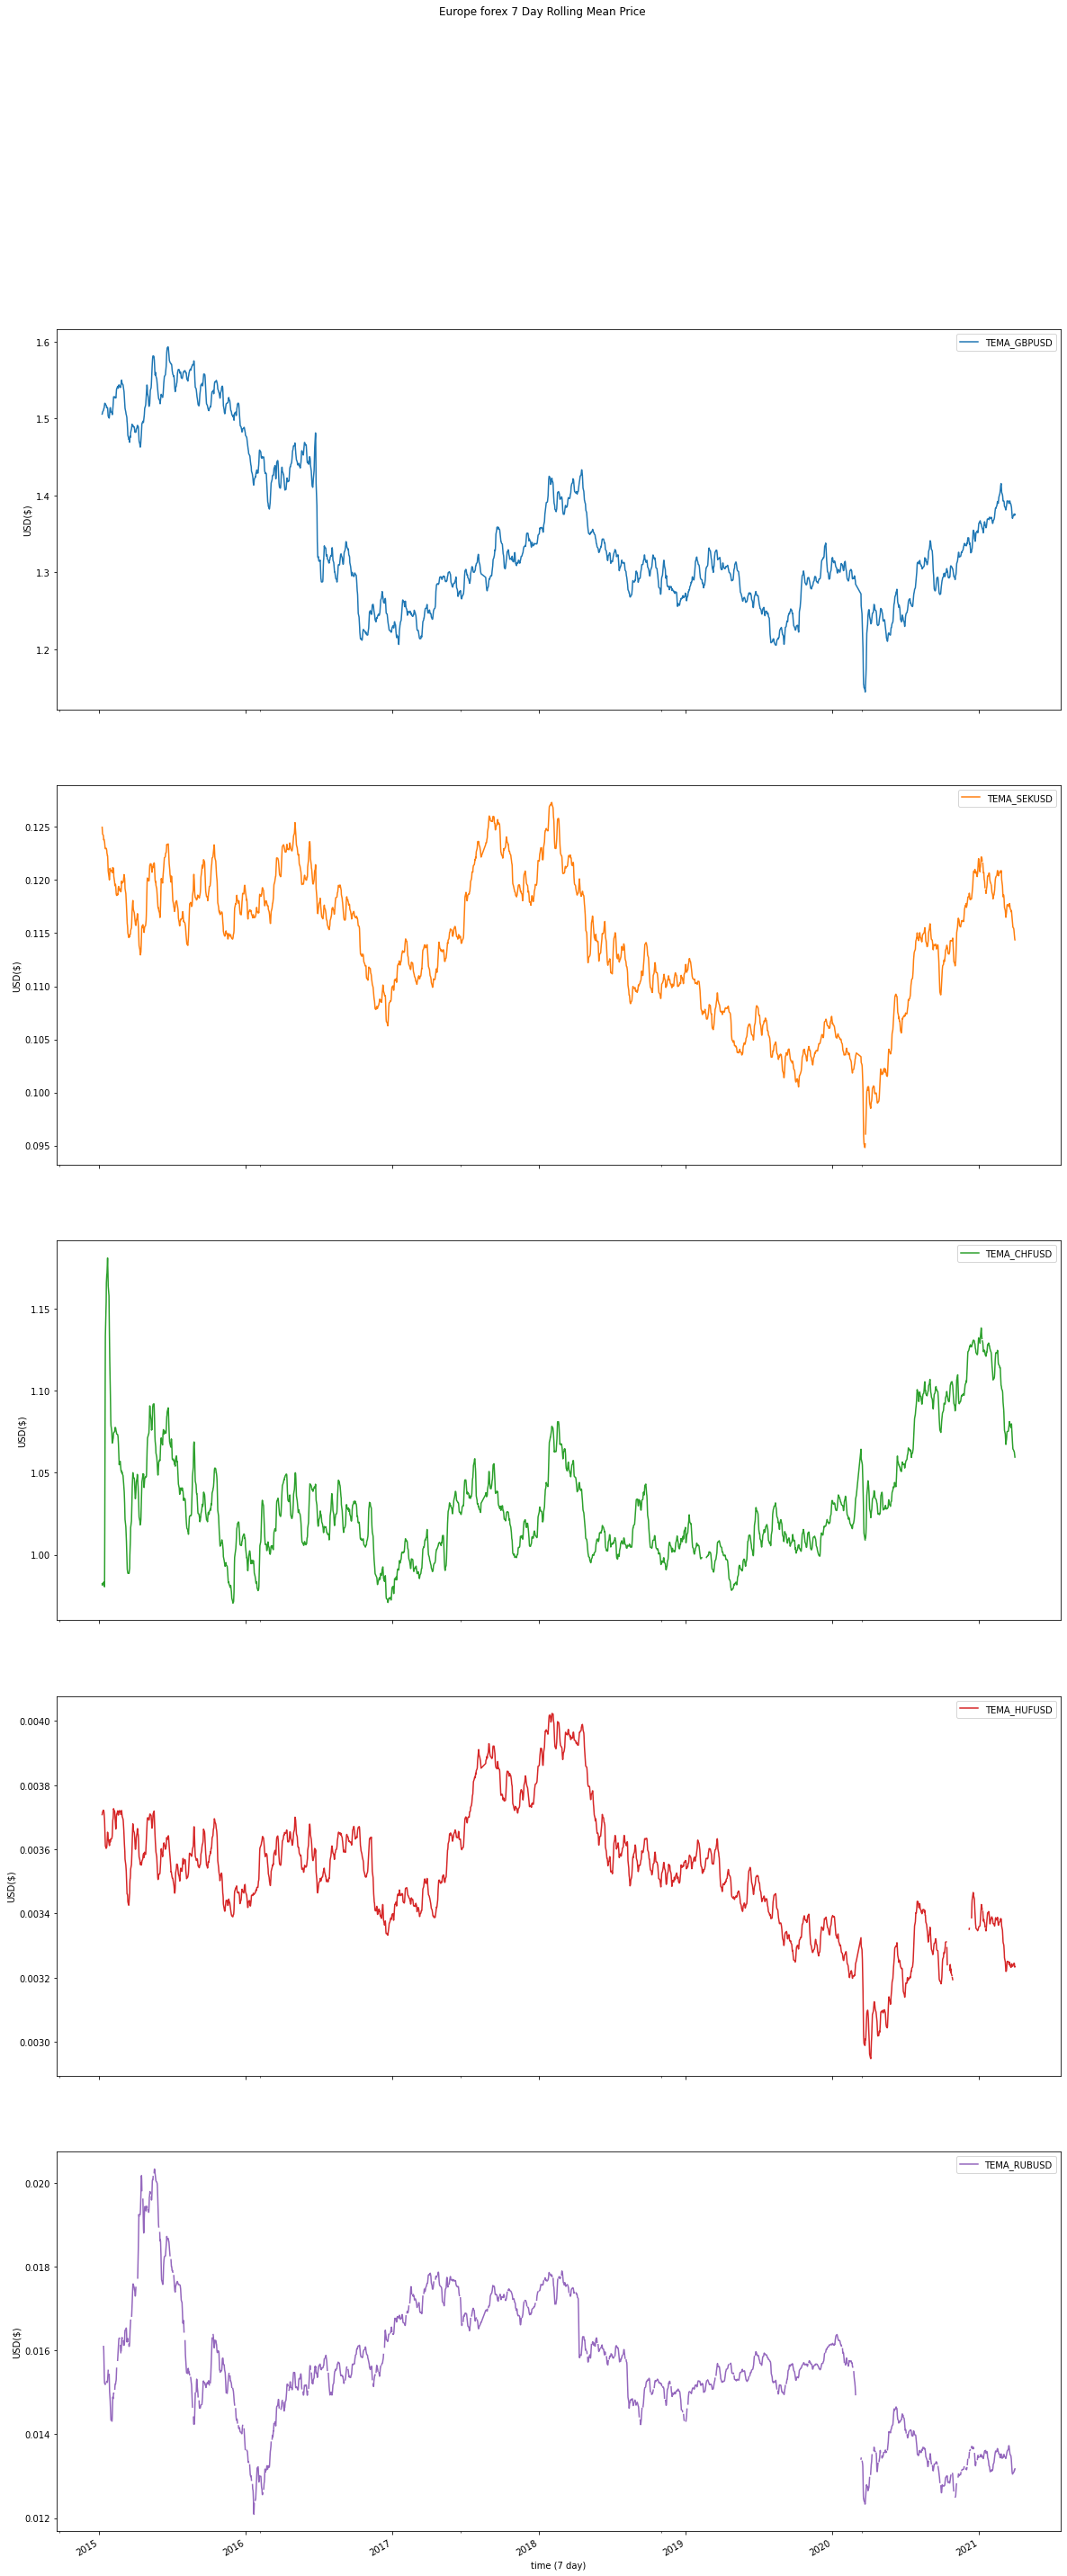

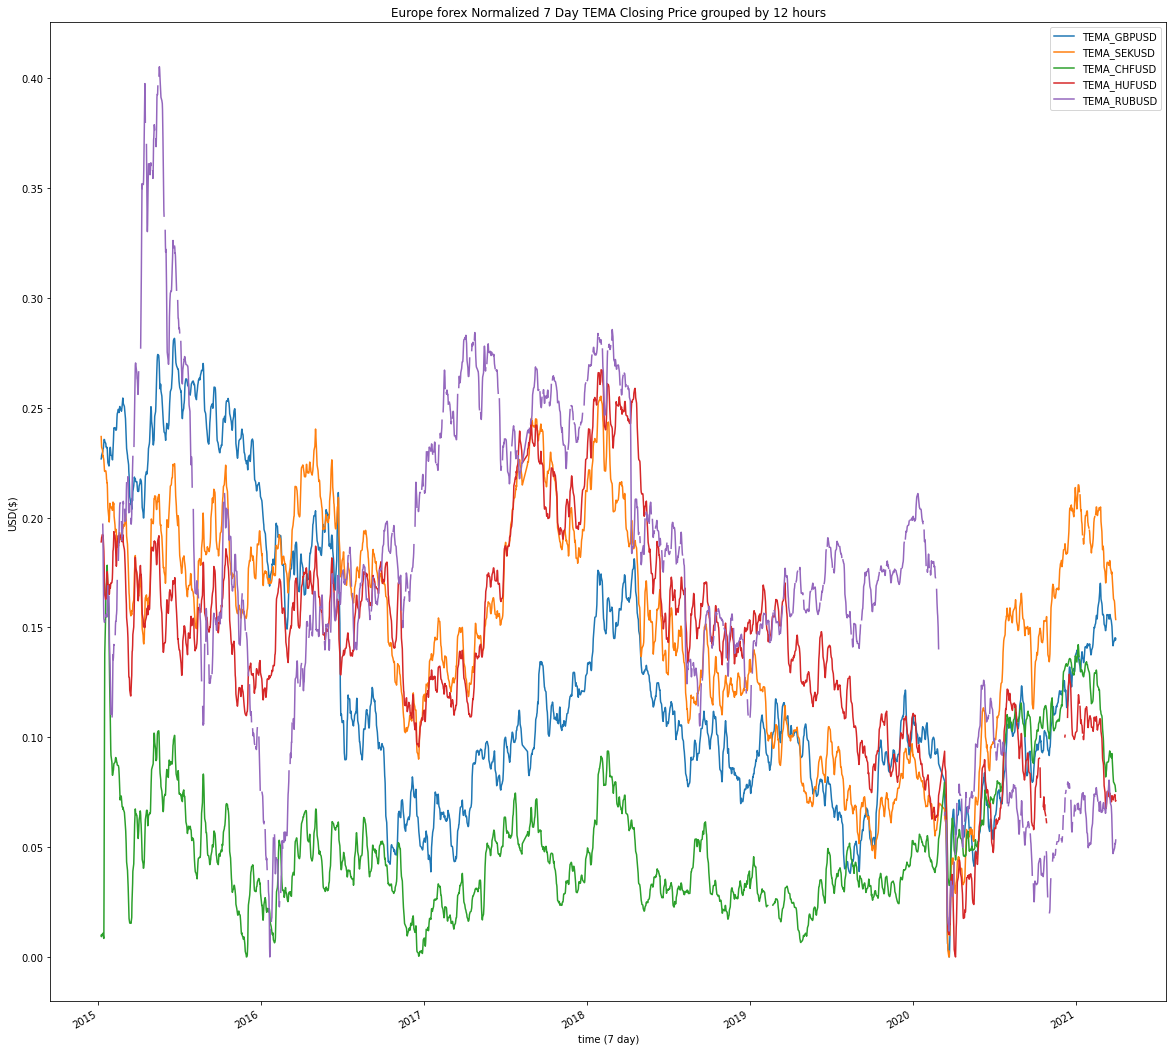

In [16]:
mRolling(name="Europe forex", lst=eu_fx)

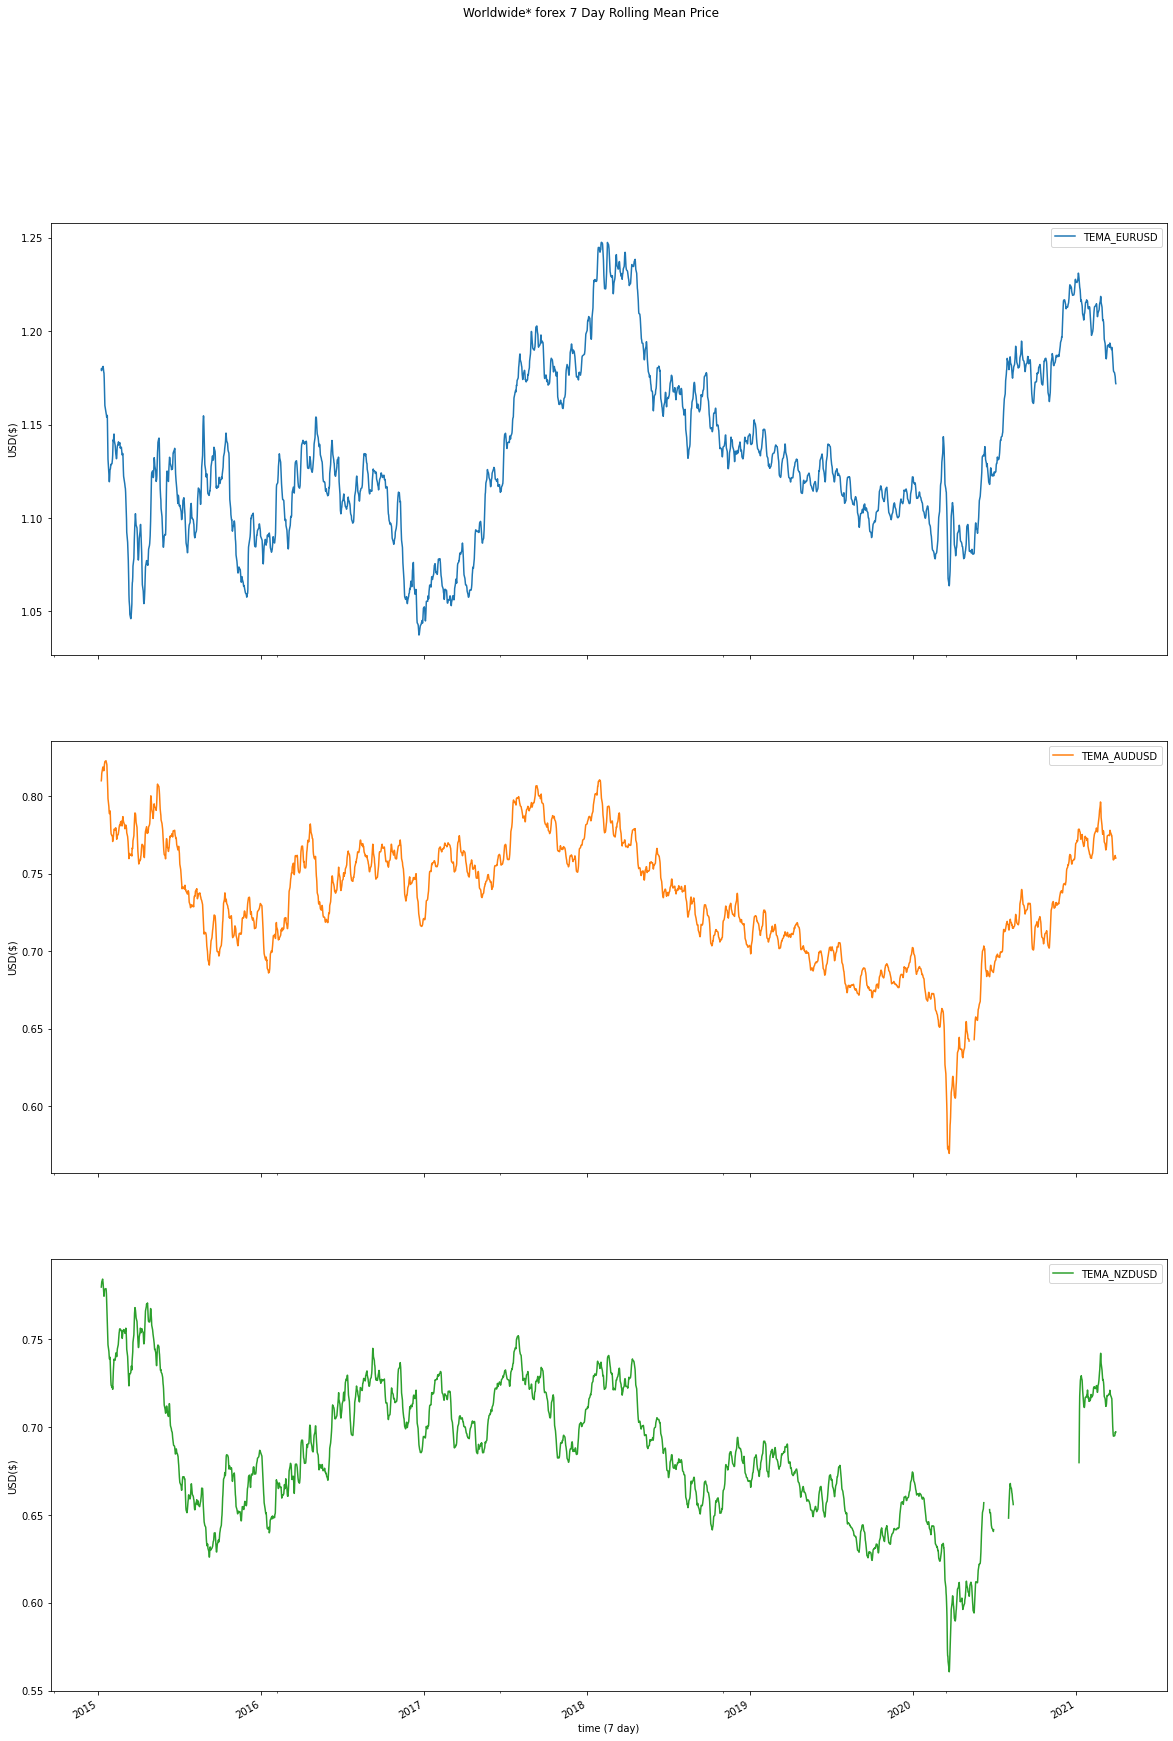

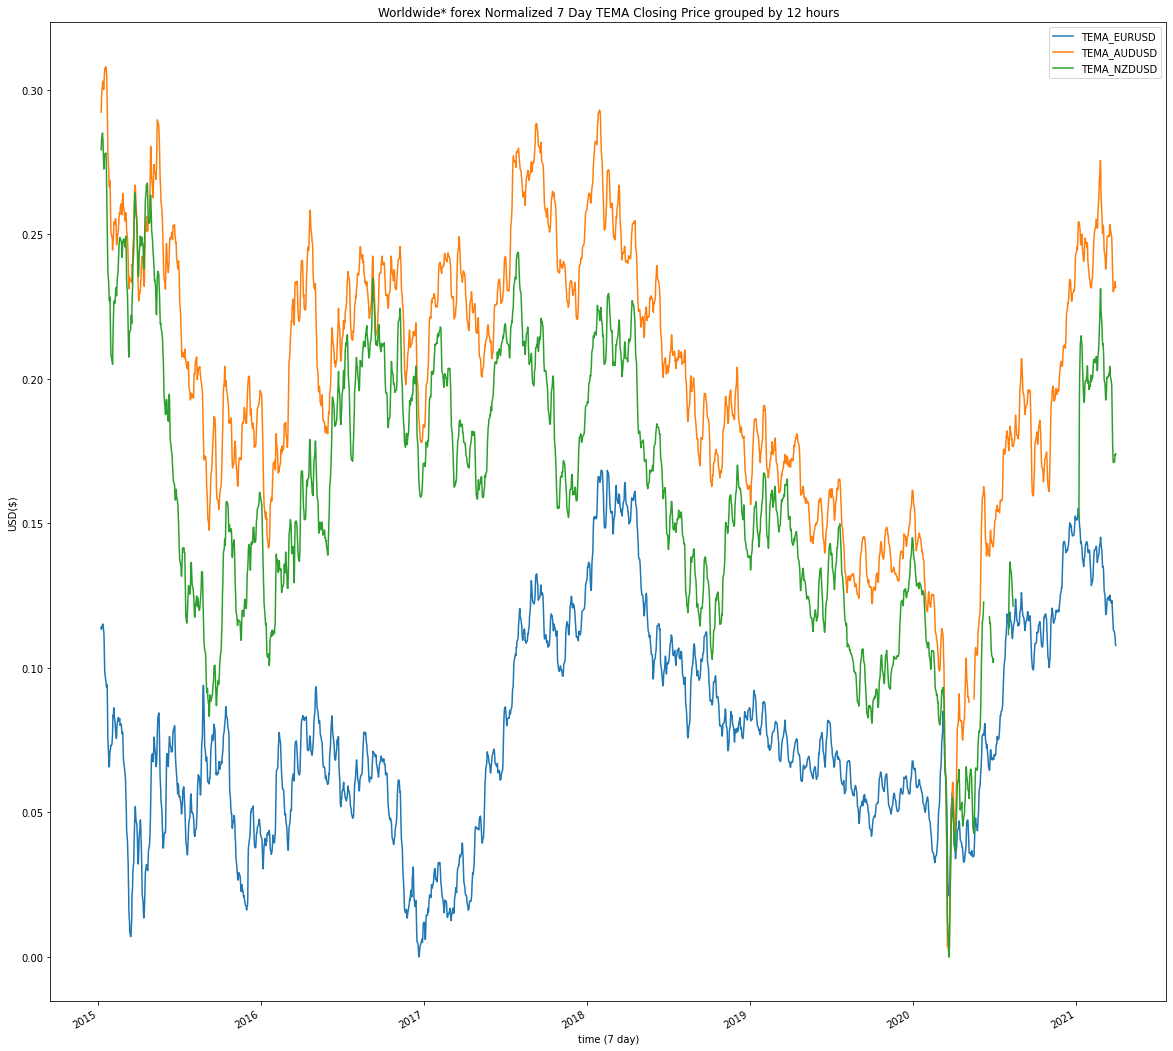

In [17]:
mRolling(name="Worldwide* forex", lst=ww_fx)

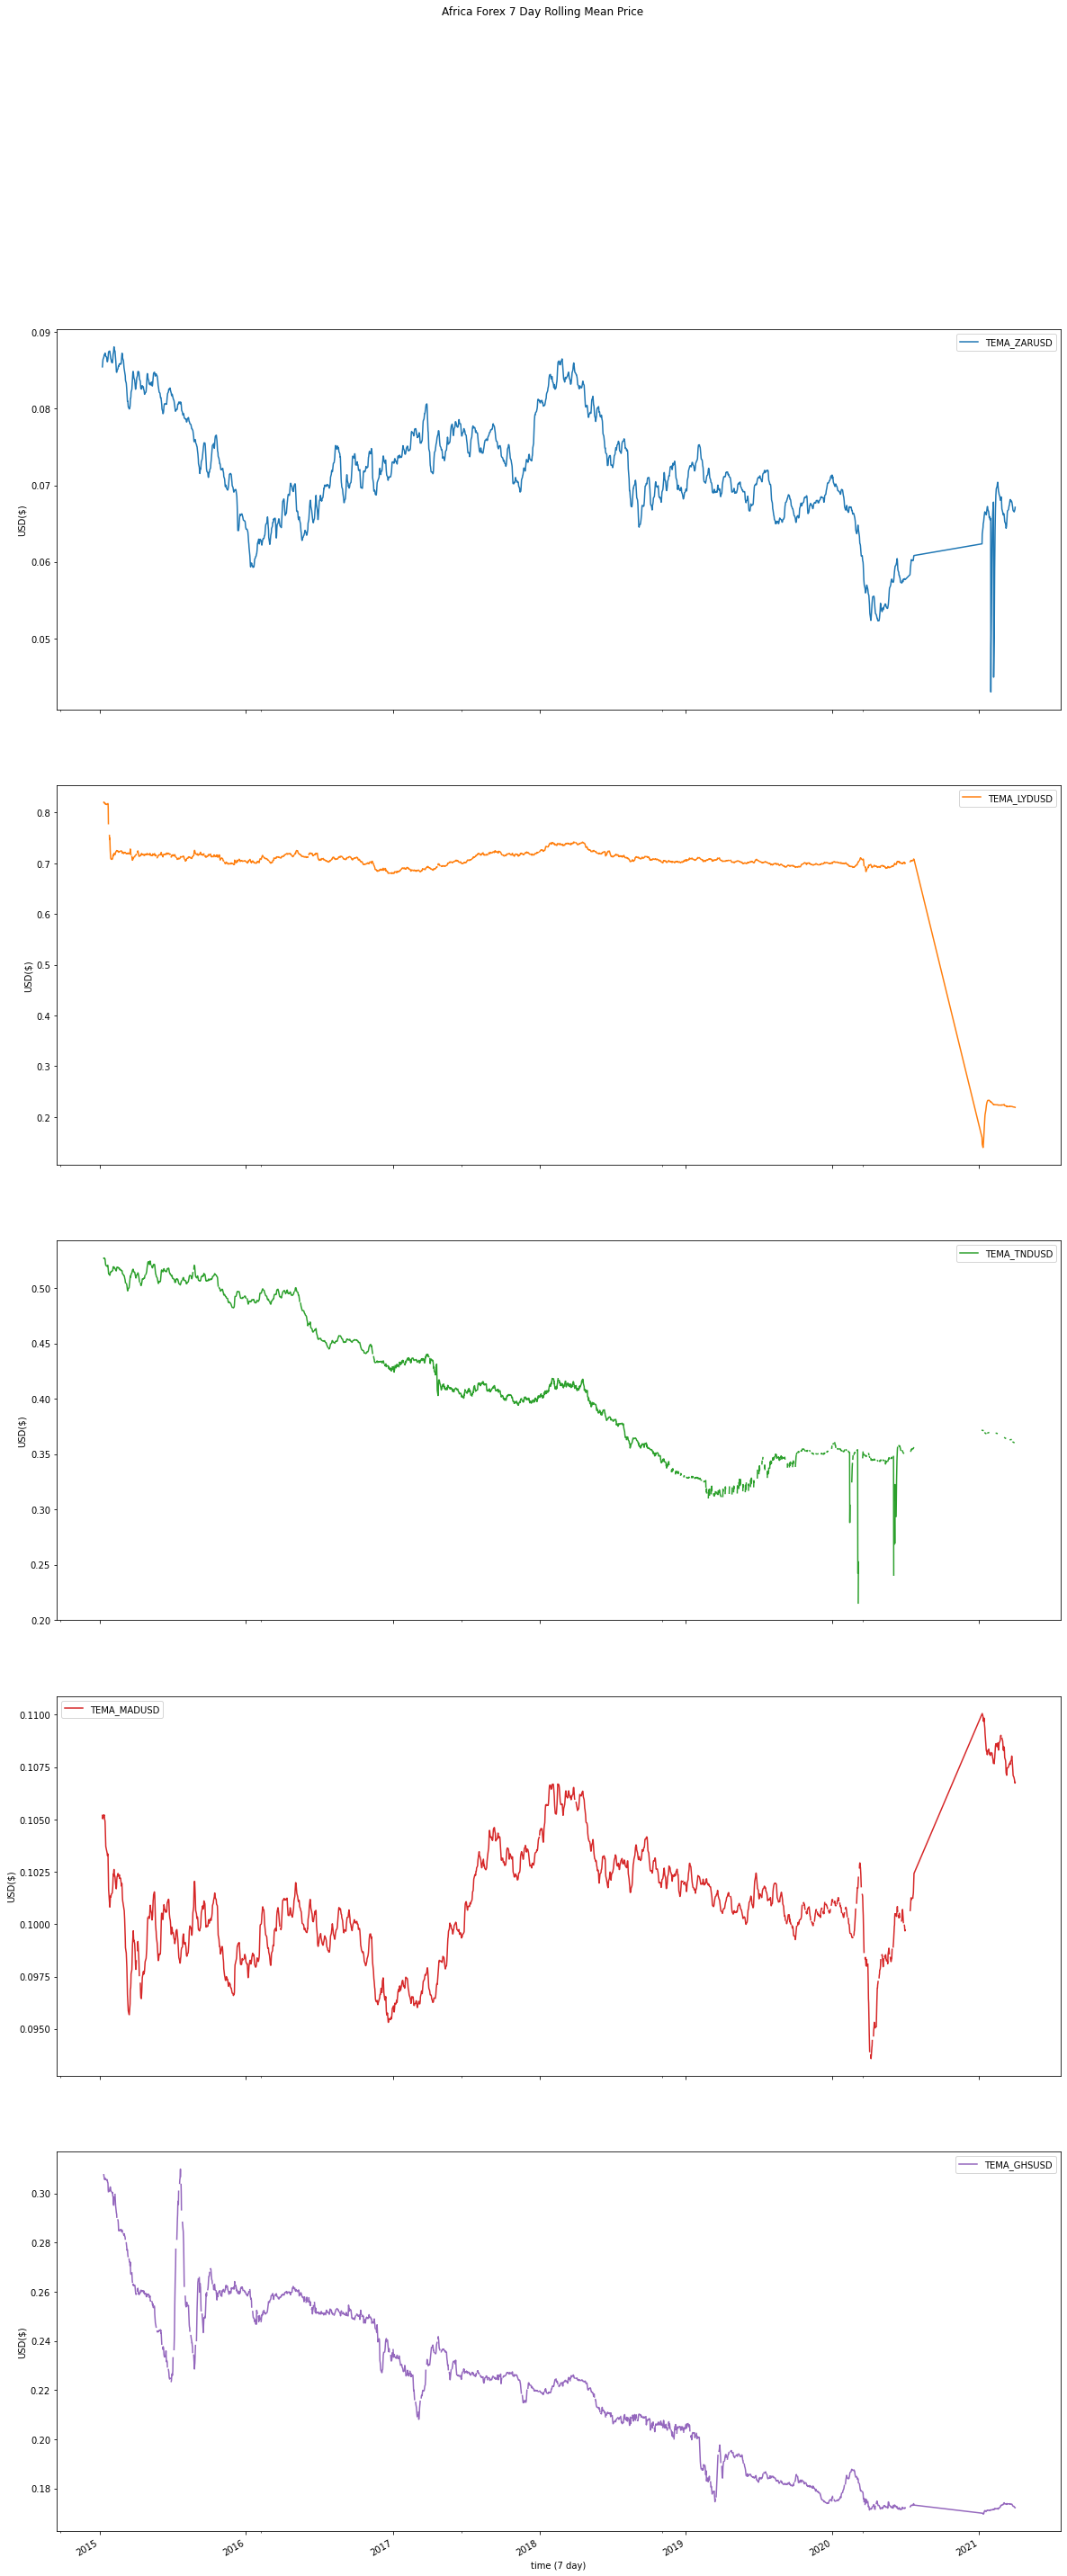

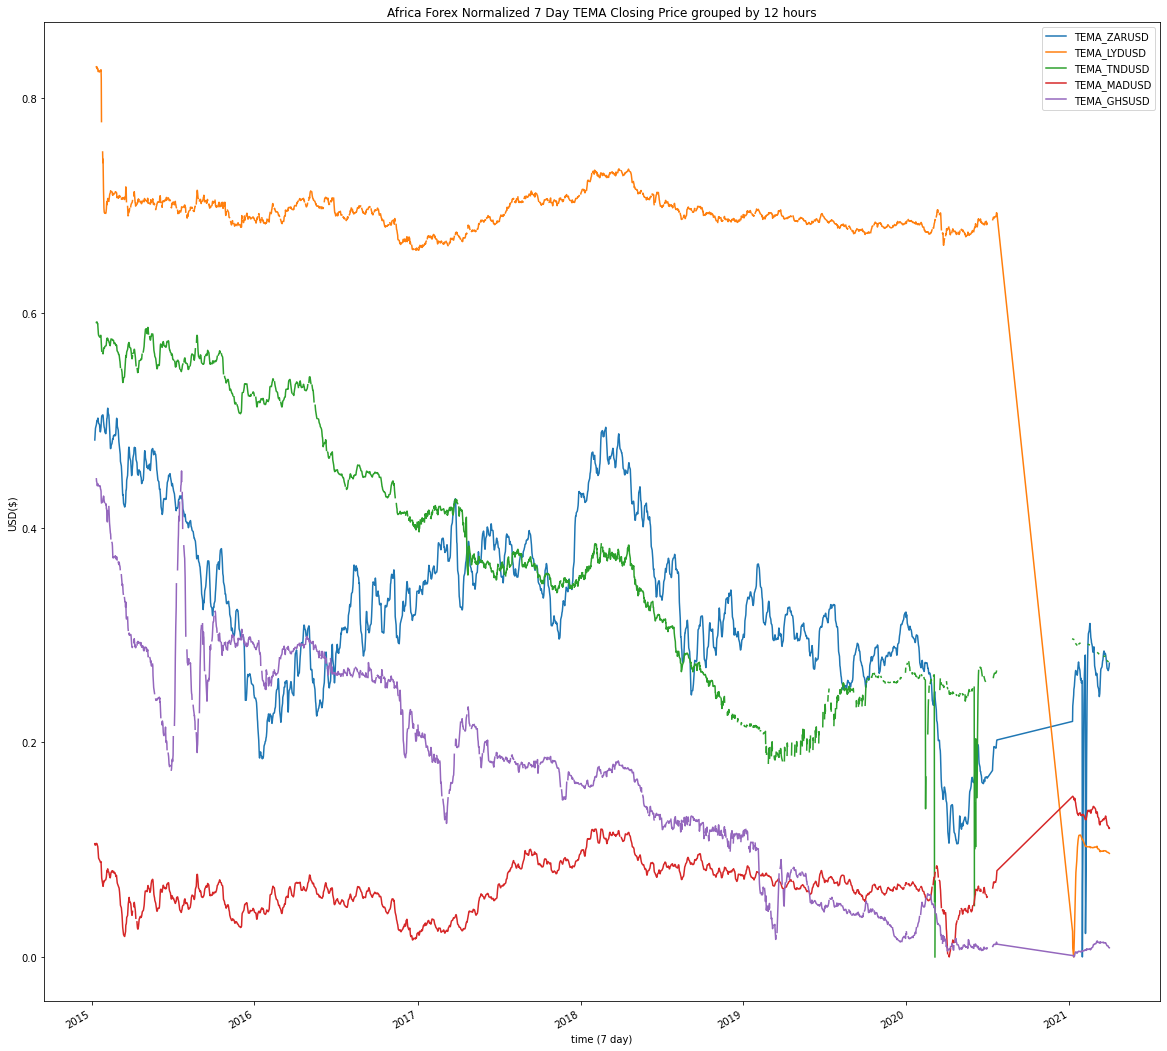

In [18]:
mRolling(name="Africa Forex", lst=af_fx)

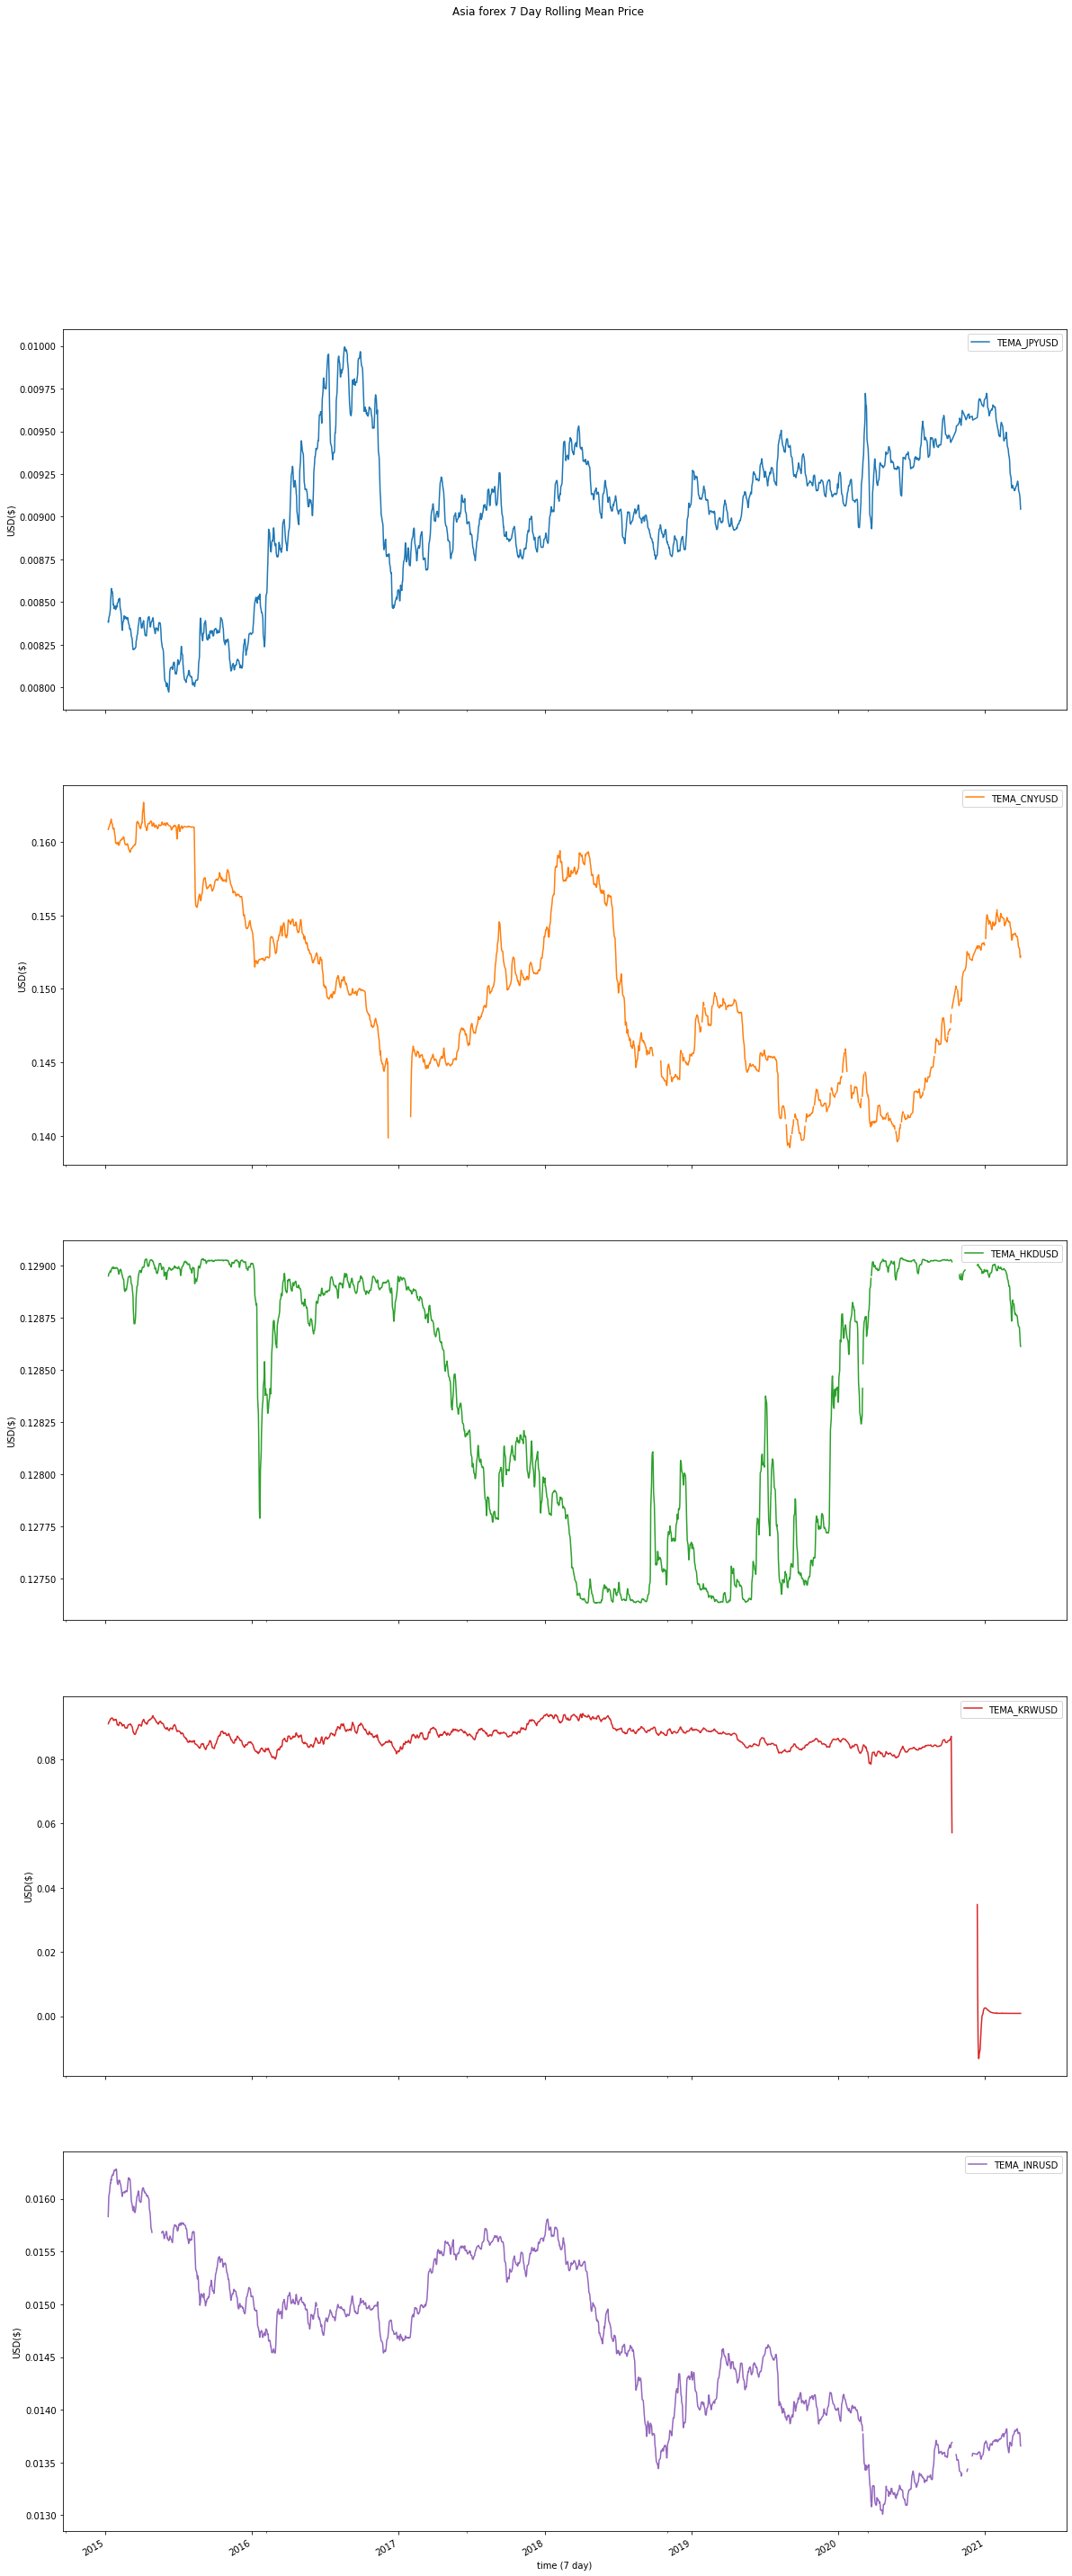

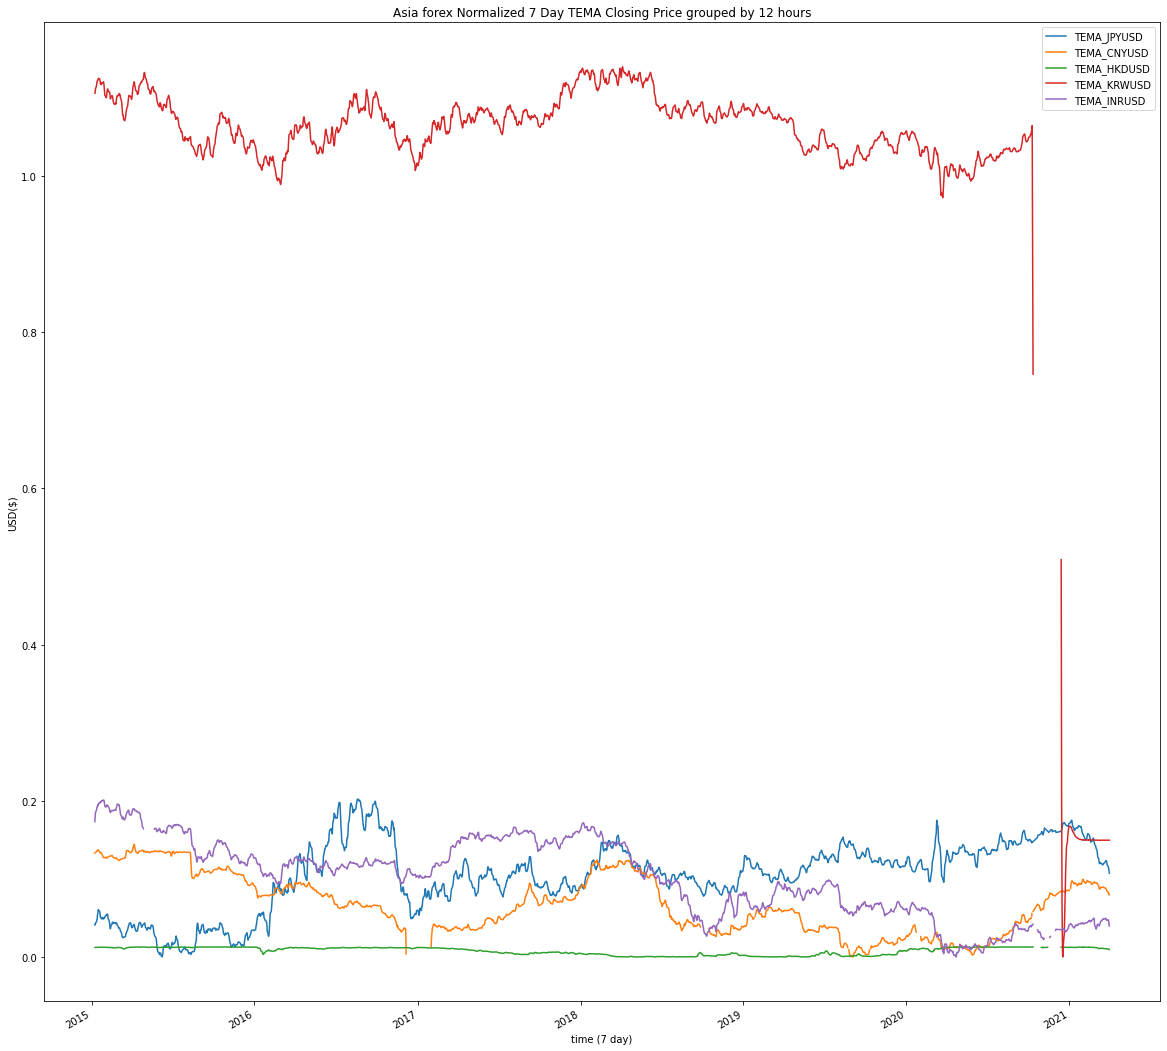

In [19]:
mRolling(name="Asia forex", lst=as_fx)

### Major Currencies


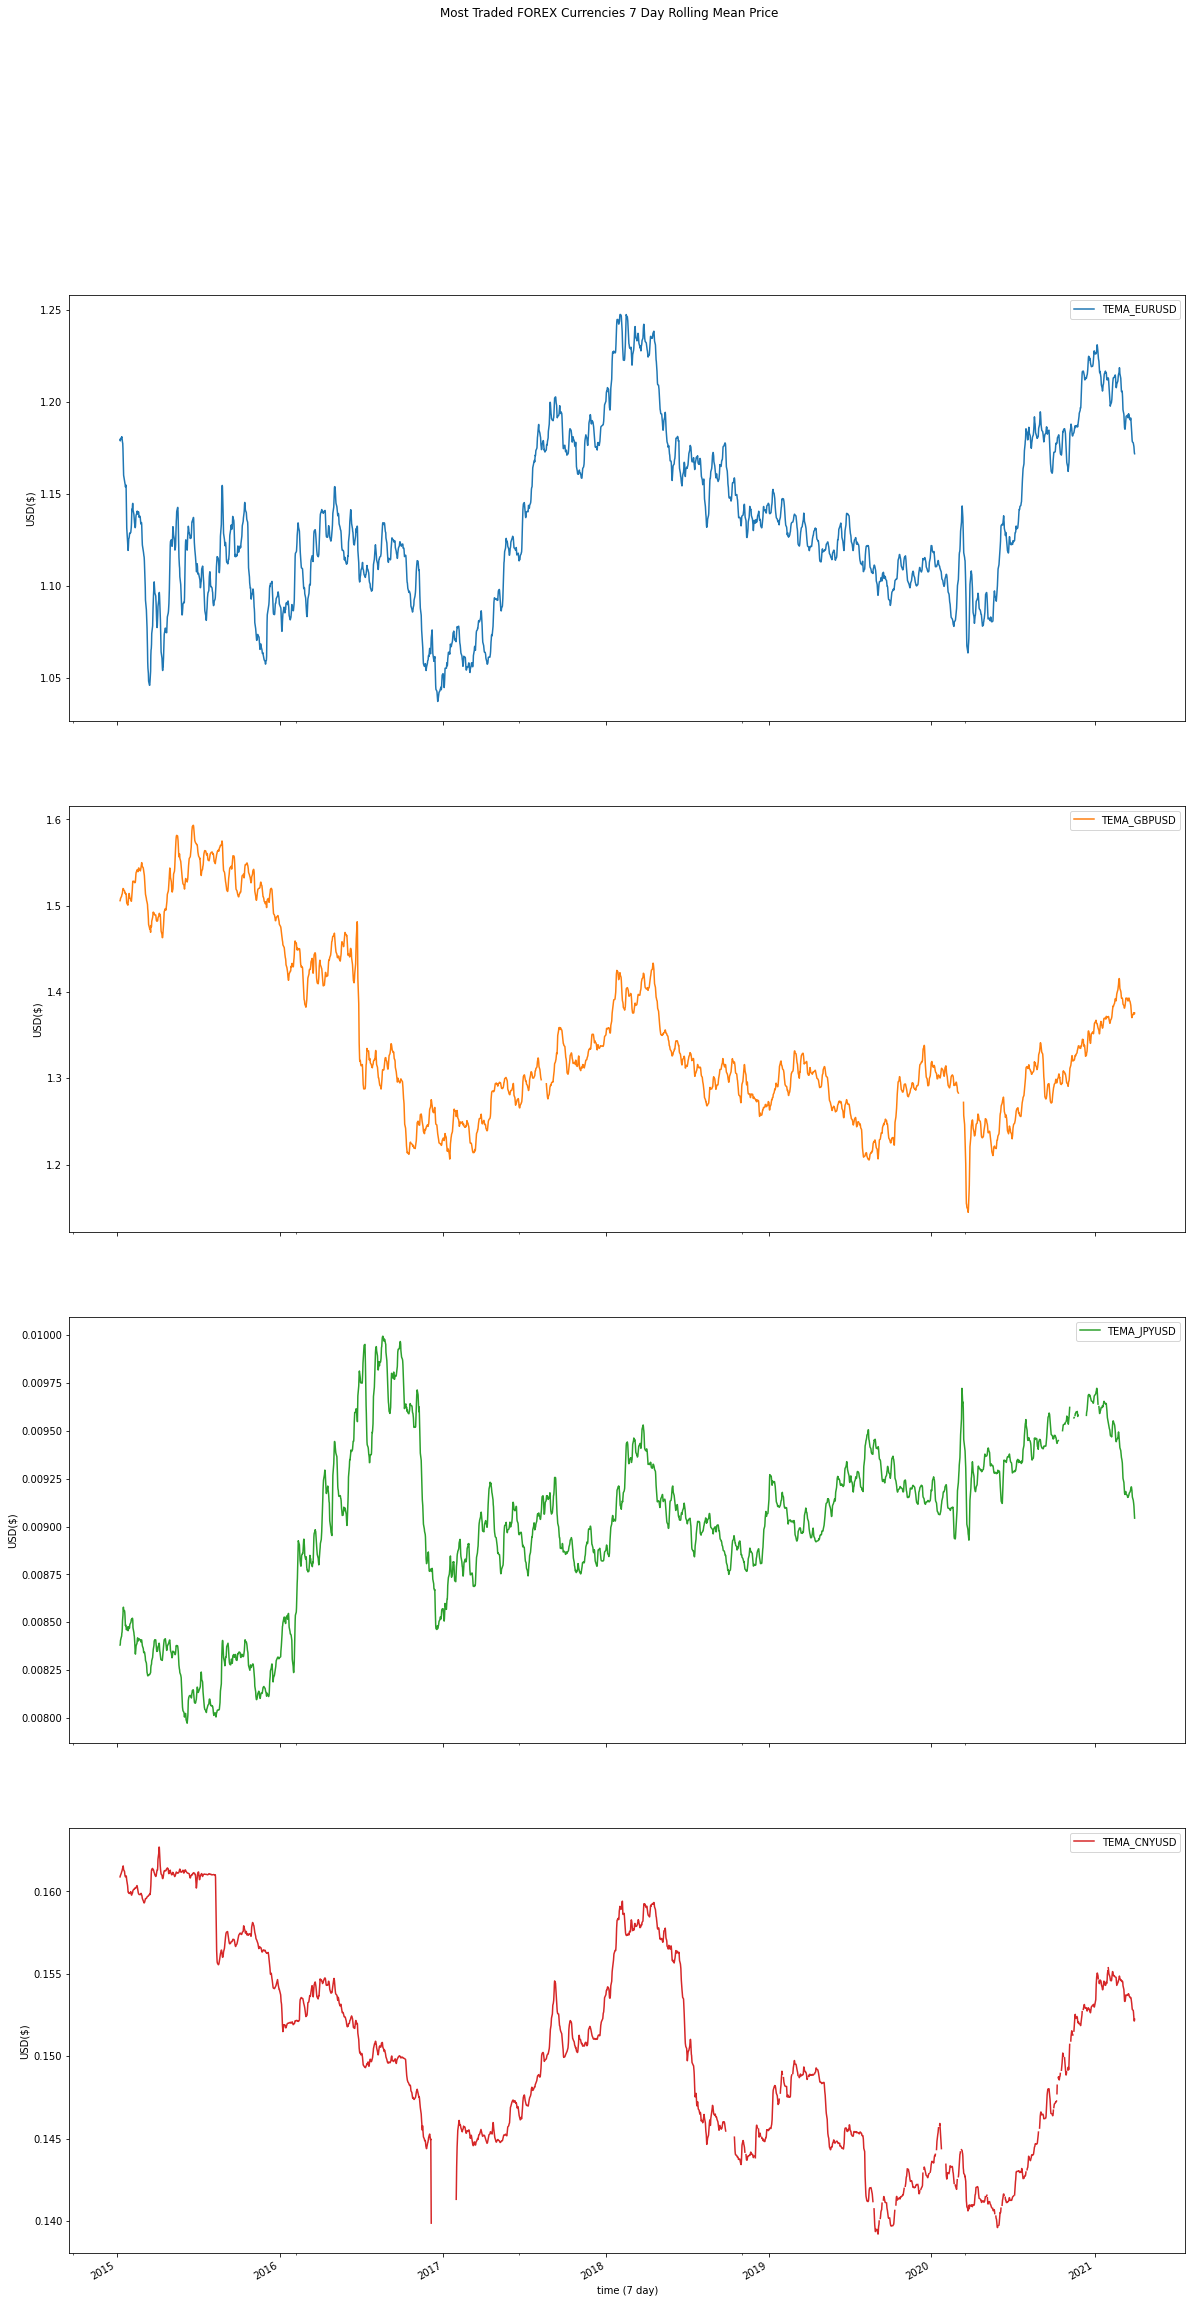

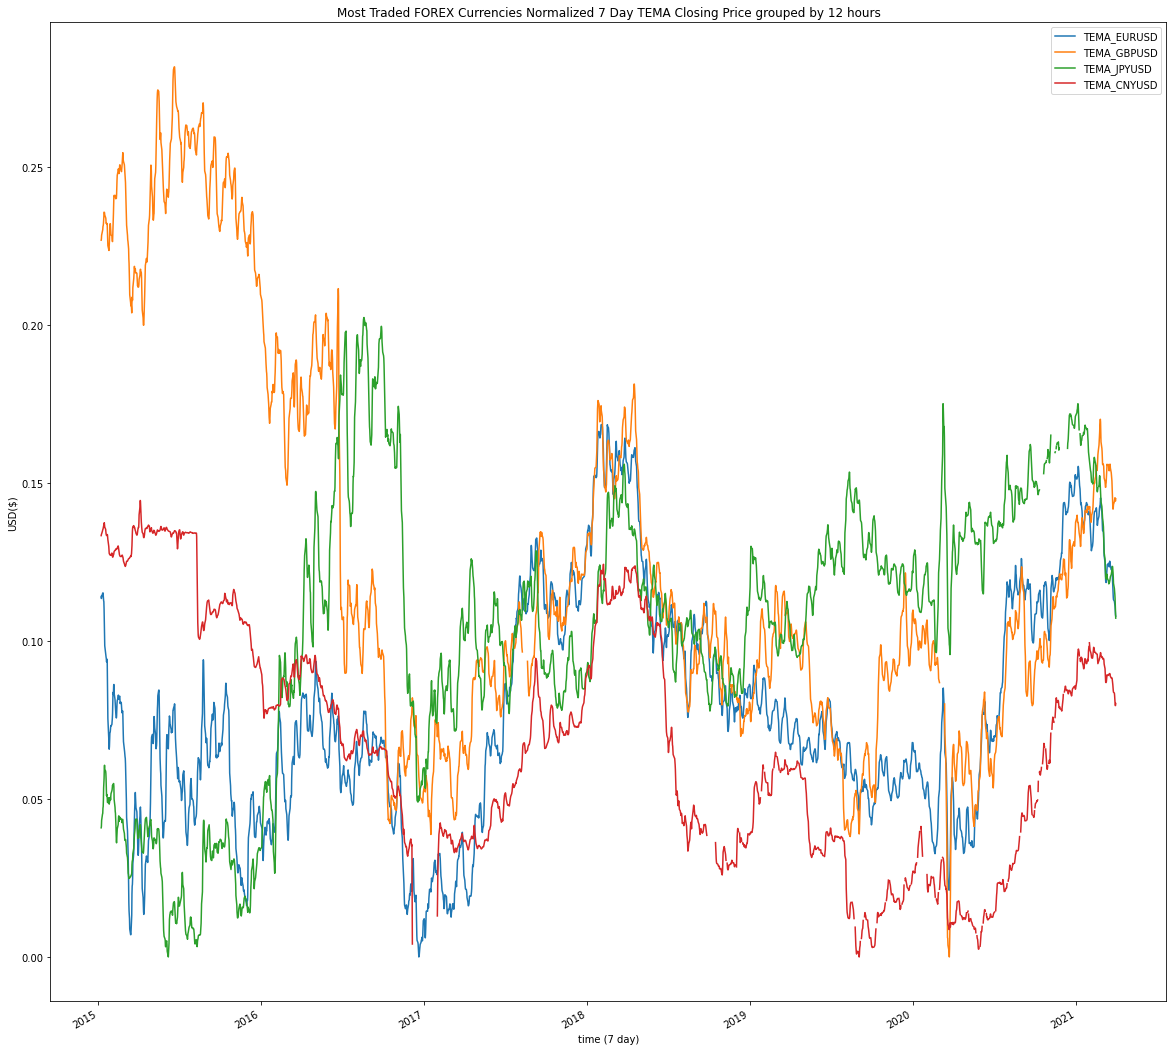

In [20]:
biggest_pairs = ['C:EURUSD', 'C:GBPUSD', 'C:JPYUSD', 'C:CNYUSD']
mRolling(name="Most Traded FOREX Currencies", lst=biggest_pairs)

## Query 2
We want to look at relationships between cryptocurrencies themselves (independent of COVID and currencies). Some coins have intentionally low correlations with other cryptocurrencies by tying themselves to tangible or fiat assets (Tether - USDT for example) to make them viable options for widespread use or for those looking for a decentralized place to store capital that does not fluctuate wildly. With the removal of these coins, we want to know how correlated cryptocurrencies are together to identify if they may serve as predictive features for cryptocurrencies themselves. Also, it is helpful to know if there are outlier cryptocurrencies (in respect to positive correlation) with the cryptocurrency market as a whole to potentially gain insight in constructing a more optimal portfolio (generally, the more diverse the better, and if items inside are negatively or neutrally correlated there is less risk). 

USDC() and USDT(tether) is pegged to the US dollar




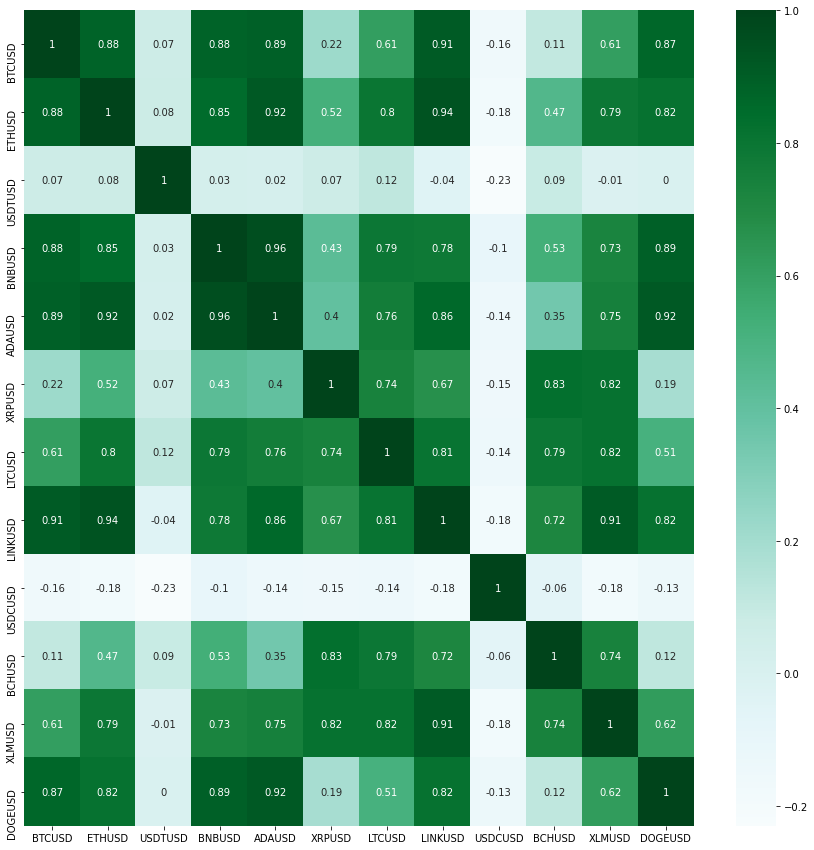

In [21]:
rolling_crypto = q_join(crypto_list)
rc_col = crypto_list
for i in range(0,len(crypto_list)):
    rc_col[i] = crypto_list[i][2:]
rolling_crypto.columns = rc_col
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(data=rolling_crypto.corr().round(2), annot=True, cmap = "BuGn")

We choose this start date as this is when most cryptocurrencies have data. 

In [22]:
r1 = rolling_crypto.loc[(rolling_crypto.index >= datetime.datetime(2018, 12, 31)) &
                       (rolling_crypto.index < datetime.datetime(2019, 12, 31))]

In [23]:
c1 = pd.DataFrame(r1.corr()["BTCUSD"].sort_values(ascending=True))
c1

BTCUSD
XLMUSD  -0.225568
XRPUSD   0.044399
USDTUSD  0.125715
ADAUSD   0.200417
LINKUSD  0.281188
LTCUSD   0.609954
DOGEUSD  0.668788
BNBUSD   0.753330
ETHUSD   0.756567
BCHUSD   0.764772
BTCUSD   1.000000
USDCUSD       NaN

In [24]:
r2 = rolling_crypto.loc[(rolling_crypto.index >= datetime.datetime(2019, 12, 31)) &
                       (rolling_crypto.index < datetime.datetime(2020, 12, 31))]

In [25]:
c2 = pd.DataFrame(r2.corr()["BTCUSD"].sort_values(ascending=True))
c2

BTCUSD
USDTUSD -0.124267
USDCUSD -0.092902
BCHUSD   0.263490
LINKUSD  0.702146
XRPUSD   0.740955
DOGEUSD  0.768400
ADAUSD   0.787486
BNBUSD   0.829880
XLMUSD   0.840042
LTCUSD   0.857508
ETHUSD   0.939104
BTCUSD   1.000000

In [26]:
r3 = rolling_crypto.loc[rolling_crypto.index >= datetime.datetime(2020, 12, 31)]

In [27]:
c3 = pd.DataFrame(r3.corr()["BTCUSD"].sort_values(ascending=True))
c3

BTCUSD
USDTUSD -0.408816
USDCUSD  0.369350
BCHUSD   0.661427
XLMUSD   0.767974
LINKUSD  0.778470
DOGEUSD  0.794334
XRPUSD   0.827258
ETHUSD   0.850917
LTCUSD   0.890560
ADAUSD   0.912963
BNBUSD   0.939642
BTCUSD   1.000000

In [28]:
dif1 = c2 - c1
dif1

BTCUSD
ADAUSD   0.587069
BCHUSD  -0.501283
BNBUSD   0.076551
BTCUSD   0.000000
DOGEUSD  0.099612
ETHUSD   0.182537
LINKUSD  0.420959
LTCUSD   0.247555
USDCUSD       NaN
USDTUSD -0.249982
XLMUSD   1.065610
XRPUSD   0.696556

In [29]:
dif2 = c3 - c2
dif2

BTCUSD
ADAUSD   0.125477
BCHUSD   0.397937
BNBUSD   0.109761
BTCUSD   0.000000
DOGEUSD  0.025934
ETHUSD  -0.088188
LINKUSD  0.076324
LTCUSD   0.033052
USDCUSD  0.462252
USDTUSD -0.284550
XLMUSD  -0.072068
XRPUSD   0.086303

In [33]:
from IPython.display import display_html 

df1 = c1
df2 = c2
df3 = c3
df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('2019')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('2020')
df3_styler = df3.style.set_table_attributes("style='display:inline'").set_caption('2021')
df2_t_styler = df2.T.style.set_table_attributes("style='display:inline'").set_caption('df2_t')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)
#display_html(df1_styler._repr_html_()+df2_styler._repr_html_() +df2_t_styler._repr_html_(), raw=True)



2019 BTCUSD 
 
 XLMUSD 
 -0.225568 
 
 
 XRPUSD 
 0.044399 
 
 
 USDTUSD 
 0.125715 
 
 
 ADAUSD 
 0.200417 
 
 
 LINKUSD 
 0.281188 
 
 
 LTCUSD 
 0.609954 
 
 
 DOGEUSD 
 0.668788 
 
 
 BNBUSD 
 0.753330 
 
 
 ETHUSD 
 0.756567 
 
 
 BCHUSD 
 0.764772 
 
 
 BTCUSD 
 1.000000 
 
 
 USDCUSD 
 nan 
 
 2020 BTCUSD 
 
 USDTUSD 
 -0.124267 
 
 
 USDCUSD 
 -0.092902 
 
 
 BCHUSD 
 0.263490 
 
 
 LINKUSD 
 0.702146 
 
 
 XRPUSD 
 0.740955 
 
 
 DOGEUSD 
 0.768400 
 
 
 ADAUSD 
 0.787486 
 
 
 BNBUSD 
 0.829880 
 
 
 XLMUSD 
 0.840042 
 
 
 LTCUSD 
 0.857508 
 
 
 ETHUSD 
 0.939104 
 
 
 BTCUSD 
 1.000000 
 
 2021 BTCUSD 
 
 USDTUSD 
 -0.408816 
 
 
 USDCUSD 
 0.369350 
 
 
 BCHUSD 
 0.661427 
 
 
 XLMUSD 
 0.767974 
 
 
 LINKUSD 
 0.778470 
 
 
 DOGEUSD 
 0.794334 
 
 
 XRPUSD 
 0.827258 
 
 
 ETHUSD 
 0.850917 
 
 
 LTCUSD 
 0.890560 
 
 
 ADAUSD 
 0.912963 
 
 
 BNBUSD 
 0.939642 
 
 
 BTCUSD 
 1.000000

This quickly shows stable coins are in fact stable

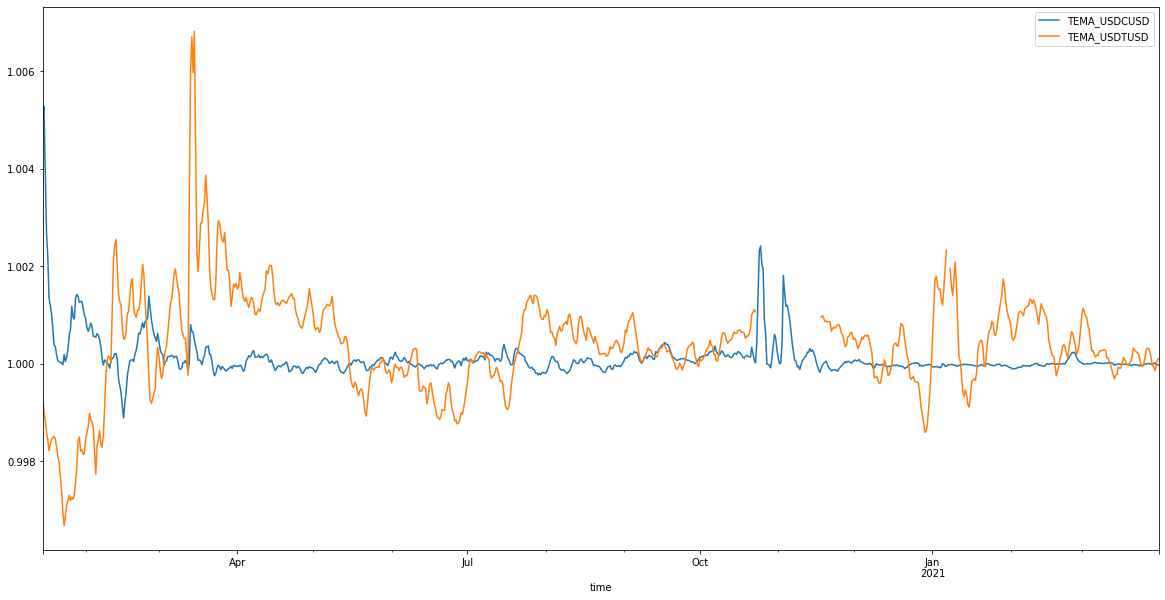

In [31]:
stable_coins = ["X:USDCUSD", "X:USDTUSD"]
df = q_join(stable_coins)
df.plot(figsize=(20,10))

The results from Q2 show the two stable coins are stable compared to bitcoin and that the correlation with bitcoin has increased over time with most cryptocurrencies.

In [32]:
!zip -r /content/figures.zip /content/figures

  adding: content/figures/ (stored 0%)
  adding: content/figures/q1/ (stored 0%)
  adding: content/figures/q1/all-rolling-subplots/ (stored 0%)
  adding: content/figures/q1/all-rolling-subplots/South America forex_subplot.png (deflated 9%)
  adding: content/figures/q1/all-rolling-subplots/Europe forex_subplot.png (deflated 8%)
  adding: content/figures/q1/all-rolling-subplots/Africa Forex_subplot.png (deflated 10%)
  adding: content/figures/q1/all-rolling-subplots/Cryptocurrency_subplot.png (deflated 14%)
  adding: content/figures/q1/all-rolling-subplots/Asia forex_subplot.png (deflated 9%)
  adding: content/figures/q1/all-rolling-subplots/Most Traded FOREX Currencies_subplot.png (deflated 8%)
  adding: content/figures/q1/all-rolling-subplots/North America forex_subplot.png (deflated 7%)
  adding: content/figures/q1/all-rolling-subplots/Worldwide* forex_subplot.png (deflated 7%)
  adding: content/figures/q1/normalized/ (stored 0%)
  adding: content/figures/q1/normalized/all_North Ameri